# Deep Learning

### MNIST Example

In [30]:
import tensorflow as tf
sess = tf.InteractiveSession()
# import MNIST data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#mnist.train.images # tensor with shape [55000, 784]
#mnist.train.labels # [55000, 10] tensor; each row is a one-hot vector

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [31]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

How to Initialize Weights:
* initialize weights with small amount of noise
    * for symmetry breaking
    * to prevent 0 gradients
* also good practice to initialize weights with a slightly positive initial bias to avoid dead neurons

In [32]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

The vanilla version of convolutional neural nets is to use a stride of one and zero padded so that the output is the same size as the input and the pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

In [33]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Now we build the first convolutional layer that will compute 32 features for each 5x5 patch. We will also have a bias vector with a component for each output channel (we have 32 output channels).

In [34]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [35]:
x_image = tf.reshape(x, [-1,28,28,1])

We then convolve `x_image` with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The `max_pool_2x2` method will reduce the image size to 14x14.

In [36]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [37]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Now that the image size has been reduced to 7x7, we add a fully-connected (or densely connected) layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [38]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

To reduce overfitting, we apply dropout before the final layer. TensorFlow's `tf.nn.dropout` operation automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [39]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Now the final layer:

In [40]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Train and evaluate the model:

In [41]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.82
step 200, training accuracy 0.92
step 300, training accuracy 0.96
step 400, training accuracy 0.88
step 500, training accuracy 0.96
step 600, training accuracy 0.9
step 700, training accuracy 0.96
step 800, training accuracy 0.98
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
step 1100, training accuracy 1
step 1200, training accuracy 0.98
step 1300, training accuracy 0.98
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 1
step 1800, training accuracy 0.96
step 1900, training accuracy 0.98
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 0.98
step 2500, training accuracy 1
step 2600, training accuracy 1
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 0.96
step 3000, tra

Code to save and restore your model.

In [42]:
# save model
saver = tf.train.Saver()
tf.add_to_collection('y_conv', y_conv)
saver.save(sess, 'convolution-model')

# restore model
sess = tf.Session()
new_saver = tf.train.import_meta_graph('convolution-model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
y_conv = tf.get_collection('y_conv')[0]
# all_vars = tf.get_collection('vars')
# for v in all_vars:
#     v_ = sess.run(v)
#     print(v_)

INFO:tensorflow:Restoring parameters from ./convolution-model


Take a sample image, see its real label and prediction.

label:  7


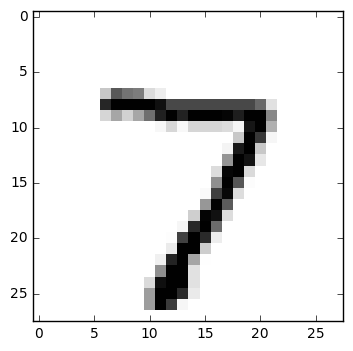

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/home/ubuntu/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-c042e7e949ec>", line 1, in <module>
    x = tf.placeholder(tf.float32, shape=[None, 784])
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [43]:
import numpy as np
from matplotlib import pyplot as plt
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[0]) if x == 1][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(mnist.test.images[0], [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: mnist.test.images[0][np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

In [ ]:
image1 = mnist.test.images[0]
image2 = mnist.test.images[1]
image3 = mnist.test.images[2]
image4 = mnist.test.images[3]
image5 = mnist.test.images[4]

In [ ]:
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[0]) if x == 1][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(image1, [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: image1[np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

In [ ]:
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[1]) if x == 0][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(image2, [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: image2[np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

In [ ]:
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[2]) if x == 1][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(image3, [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: image3[np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

In [ ]:
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[3]) if x == 1][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(image4, [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: image4[np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

In [ ]:
# output categories
labels = list(range(0,10))
index = [i for i, x in enumerate(mnist.test.labels[4]) if x == 1][0]
# print label
print("label: ", labels[index])

# show test image
test = np.reshape(image5, [28, 28])
plt.imshow(test, cmap='Greys', interpolation='nearest')
plt.show()

# predict test image
feed_dict = {x: image5[np.newaxis], keep_prob: 1.0}
classification = np.argmax(y_conv.eval(feed_dict)[0])
print("prediction:", classification)

You can even visual the model:

## Exercises

**TensorFlow**

Train the convolutional model above and use it classify the following images:

In [ ]:
image1 = mnist.test.images[0]
image2 = mnist.test.images[1]
image3 = mnist.test.images[2]
image4 = mnist.test.images[3]
image5 = mnist.test.images[4]

## References

* [TensorFlow](https://www.tensorflow.org/)
* [TensorFlow installation guide](https://www.tensorflow.org/install/)
* [TensorFlow introduction](https://www.tensorflow.org/get_started/get_started)
* [TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)
* [TensorFlow embedding visualizations](https://www.tensorflow.org/get_started/embedding_viz)
* [Convolutional Neural Network tutorial](http://neuralnetworksanddeeplearning.com/chap6.html)